In [1]:
import sys,os
sys.path.insert(0, os.path.abspath(os.path.join("../../src")))

# Example jupyter notebook

## Segment pulses of activity in videos

### table of all embryos

In [2]:
import numpy as np
import pandas as pd
from utils import dir_data,dir_out,pjoin
embryos = pd.read_csv(pjoin([dir_data,'embryos.csv']),skipinitialspace=True,comment='#').set_index('ID')
embryos

,phenotype,LabelG,LabelR,tRes,nEnd,note,contractility,comment
ID,,,,,,,,
20210409_7,plst,ROK,NMY,0.6,400,SD3050,NaN,EXAMPLE_6
20210410_2,unc60,ROK,NMY,0.6,700,SD3050,NaN,weak
20210410_6,unc60,ROK,NMY,0.6,400,SD3050,NaN,weak
20210410_7,unc60,ROK,NMY,0.6,450,SD3050,NaN,NaN
20210410_10,unc60,ROK,NMY,0.6,300,SD3050,NaN,NaN
...,...,...,...,...,...,...,...,...
20191129_16,ani+nmy,ROK,None,0.6,590,SD30,NaN,NaN
20191128_13,nmy,UTR,None,0.6,474,SD30,NaN,NaN
20191128_14,nmy,UTR,None,0.6,581,SD30,NaN,NaN


In [3]:
embryos.loc[embryos['phenotype']=='spd']

,phenotype,LabelG,LabelR,tRes,nEnd,note,contractility,comment
ID,,,,,,,,
20181116_3,spd,ROK,NMY,0.4,500,TIRF2030,NaN,NaN
20181116_4,spd,ROK,NMY,0.4,650,TIRF2030,NaN,NaN
20181116_5,spd,ROK,NMY,0.4,900,TIRF2030,NaN,NaN
20181116_6,spd,ROK,NMY,0.4,350,TIRF2030,NaN,NaN
20190317_5,spd,ROK,LA,0.4,600,TIRF2025,NaN,NaN
20190317_7,spd,ROK,LA,0.4,650,TIRF2025,NaN,NaN
20201118_18,spd,ROK,LA,0.4,500,TIRF3030,NaN,NaN
20201118_19,spd,ROK,LA,0.4,350,TIRF3030,NaN,NaN
20190524_3,spd,ROK,LA,0.6,550,SD3050,NaN,NaN


### read raw tiff image

In [4]:
ID,phenotype = '20190524_5','spd'
from utils import directories
from measure.preprocess import read_raw
dir_raw = pjoin([dir_data,directories['rawtif'],phenotype,ID])

result_read_raw = read_raw([dir_out,'',ID],dir_raw,ID,embryos.loc[ID]['LabelR'],embryos.loc[ID]['tRes'],embryos.loc[ID]['nEnd'])#read raw 16-bit tif files
result_read_raw.keys()


dict_keys(['savedir', 'img', 'imr'])

In [5]:
img = result_read_raw['img']
img.shape

(346, 512, 512)

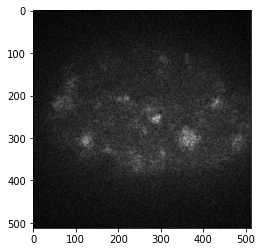

In [6]:
frame = 10
import matplotlib.pyplot as plt
plt.imshow(img[frame],cmap='gray')

### pixels in the embryo

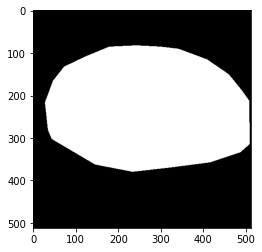

In [7]:
tRes = embryos.loc[ID]['tRes']
from measure.preprocess import read_outline
outline = read_outline(pjoin([dir_data,directories['outline'],'poly-'+ID+'.tif']))#read binary mask of the outline of the embryo
plt.imshow(outline,cmap='gray')

### correct photobleach

In [8]:
from measure.segmentation import bleach_correction,group_diff
_,_,bc = bleach_correction(img, outline, window_length=int(40//tRes)*2+1, videozmin=int(100//tRes))#subtract photobleach trend in time for all pixels in each frame
bc.shape,bc.dtype

((346, 512, 512), dtype('uint16'))

### grouped average in time

In [9]:
result_grouped = group_diff(bc,outline,tRes)
for k,v in result_grouped.items():
    info = [type(v)]
    if isinstance(v, np.ndarray):
        info += [v.shape,v.dtype]
    elif hasattr(v, "__len__"):
        info += [len(v)]
    print(k,*info)


RAW <class 'numpy.ndarray'> (173, 512, 512) uint16
SMOOTH <class 'numpy.ndarray'> (173, 512, 512) float32
DIFF <class 'numpy.ndarray'> (173, 512, 512) float32
zgroups <class 'list'> 173


### excitation = temporal derivative > threshold

[Text(0.5, 1.0, 'excitation')]

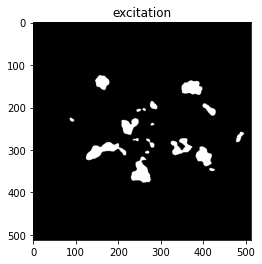

In [10]:
threshold = 1.3# threshold value
diff = result_grouped['DIFF']
EXC = diff>threshold
EXC[:,~outline] = False# remove excitation outside of embryo

plt.imshow(EXC[frame],cmap='gray')
ax = plt.gca()
ax.set(title='excitation')

[Text(0.5, 1.0, 'excitation')]

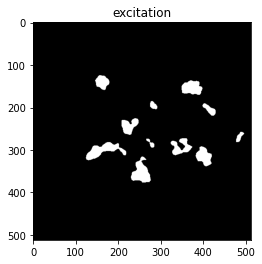

In [11]:
# remove excitation regions smaller than 100 pixels at each frame
nonzeroz = lambda stk:np.where(stk.max(1).max(1))[0]
nzzs = nonzeroz(EXC)
from skimage.morphology import remove_small_objects
for z in nzzs:
    EXC[z] = remove_small_objects(EXC[z], min_size=10**2)

plt.imshow(EXC[frame],cmap='gray')
ax = plt.gca()
ax.set(title='excitation')

[Text(0.5, 1.0, 'new excitation')]

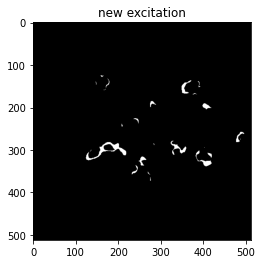

In [12]:
NEWEXC = np.zeros(EXC.shape,bool)
NEWEXC[nzzs[1:]] = np.diff(EXC[nzzs].astype(int),axis=0)>0

plt.imshow(NEWEXC[frame],cmap='gray')
ax = plt.gca()
ax.set(title='new excitation')

## ROK temporal difference in labled pulsing regions

In [13]:
from measure.pixel_intensity import roi_to_stkmask
#path of manually labeled excitation circles
path_circles = pjoin([dir_data,directories['circles'], [embryos.loc[ID]['phenotype'],ID]])+'.zip'
#read manually labeled excitation circles
circles_mask = roi_to_stkmask(img.shape,result_grouped['zgroups'],path_circles)
circles_mask.shape,circles_mask.dtype


((346, 512, 512), dtype('bool'))

In [14]:
dz=np.arange(-15,6)
from measure.pixel_intensity import intensity_ts
diffts = intensity_ts(circles_mask,result_grouped['DIFF'],dz,outline)
diffts.shape

(29, 21)

[Text(0.5, 0, 'time (s)'),
 Text(0, 0.5, 'ROK temporal difference'),
 Text(0.5, 1.0, 'labeled pulsing regions in one embryo')]

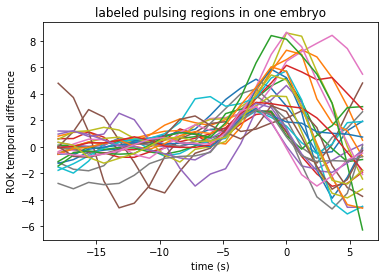

In [15]:
# plot ROK temporal difference in labeled pulsing regions
for i in range(diffts.shape[0]):
    plt.plot(dz*1.2,diffts[i])
ax = plt.gca()
ax.set(xlabel='time (s)',ylabel='ROK temporal difference',title='labeled pulsing regions in one embryo')

## Measure summary statistics

### detect contour of excitation regions

In [16]:
from measure.contour import findContours
blobs = findContours(EXC)
blobs.keys()

dict_keys([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169])

In [17]:
blobs[frame]

In [18]:
for k,v in dict(vars(blobs[frame][1])).items():
    info = [type(v)]
    if isinstance(v, np.ndarray):
        info += [v.shape,v.dtype]
    elif hasattr(v, "__len__"):
        info += [len(v)]
    print(k,*info)


pixels <class 'numpy.ndarray'> (1267, 2) int64
pixelsp <class 'list'> 1267
cnt <class 'numpy.ndarray'> (131, 2) int32
cntp <class 'list'> 131
pz <class 'numpy.int64'>
j <class 'int'>


### measure polygon local deformations perpendicular to its edge

In [19]:
from measure.edgespeed import point_velocity
speed,speedmask = point_velocity(blobs,NEWEXC,outline)
speed.shape,speed.dtype

((3160,), dtype('int64'))

[Text(0.5, 0, 'speed'), Text(0, 0.5, 'density')]

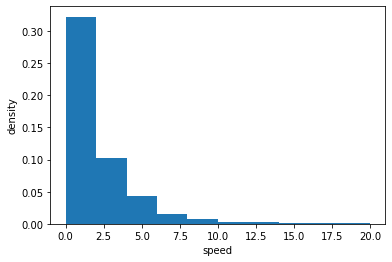

In [20]:
plt.hist(speed,density=True)

ax = plt.gca()
ax.set(xlabel='speed',ylabel='density')

### link polygons recursively to map pulse trajectories

In [21]:
from measure.link import connected_components
area = connected_components(blobs)#cumulative area in pixels
area = area/outline.sum()# cumulative area in fraction of embryo surface

area

0.11822207442153534

### measure periodicity of local time series

In [22]:
NMAX = 100
from measure.recurrence import frequency,waittime
freq = frequency(NEWEXC[:NMAX],outline)#frequency of new excitations
wait = waittime(NEWEXC[:NMAX],outline,50)#wait time of new excitations


(114268,) int64


[Text(0.5, 0, 'freq'), Text(0, 0.5, 'density')]

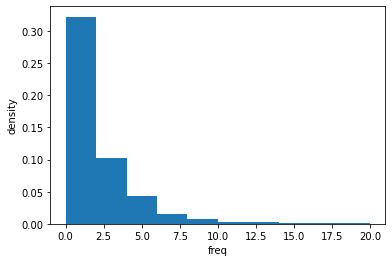

In [23]:
print(freq.shape,freq.dtype)

plt.hist(speed,density=True)

ax = plt.gca()
ax.set(xlabel='freq',ylabel='density')

(102650,) int64


[Text(0.5, 0, 'wait'), Text(0, 0.5, 'density')]

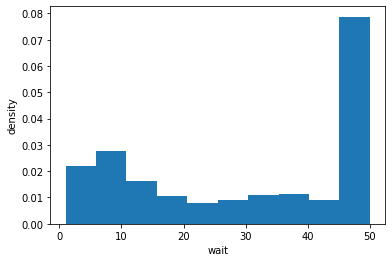

In [24]:
print(wait.shape,wait.dtype)

plt.hist(wait,density=True)

ax = plt.gca()
ax.set(xlabel='wait',ylabel='density')

In [25]:
from measure.pixel_intensity import ccfbf

dz=np.arange(-5,6)
ccf_col = lambda ts,ts2: np.stack([ccfbf(ts[:,pixel], ts2[:,pixel]) for pixel in np.arange(ts.shape[1])],0)
g = result_grouped['SMOOTH'][1:NMAX-1,outline]
acf_smooth = ccf_col(g,g)


[Text(0.5, 0, 'time offset'), Text(0, 0.5, 'autocorrelation')]

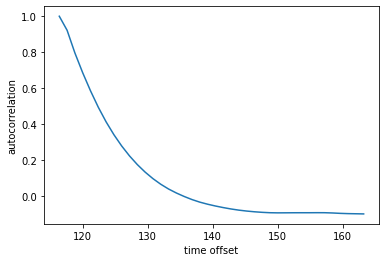

In [27]:
lacf = g.shape[0]
dz = np.arange(1-lacf,lacf)
mhalf = np.logical_and(dz>=0,dz<40)

plt.plot(np.arange(acf_smooth.shape[1])[mhalf]*1.2,acf_smooth.mean(0)[mhalf])
ax = plt.gca()
ax.set(xlabel='time offset',ylabel='autocorrelation')